## Extracting Comoving Cartesian Coordinates

### Aidan Cloonan

### August 2020

In this notebook, I'm using H5py and dask arrays to extract cartesian coordinates of all member galaxies found in redMaPPer clusters from HDF5 files. This involves compiling data for all objects in cosmoDC2, and these packages work more efficiently than GCR does on this same task.

Later, I can use this information to calculate quadrupole moment tensors for our clusters, profiling the distribution of member galaxies. We can use this to estimate cluster ellipticity and orientation.

Note that the catalog GCR would read in has defined spatial coordinates as a comoving Cartesian space, so the its coordinates are in units of $\rm Mpc$ $\rm h^{-1}$. The HDF5 files found in the cosmoDC2 directory do not use the same definition, and they instead use $\rm Mpc$. We must correct for this by dividing our extracted coordinates by the dimensionless Hubble parameter.

In [1]:
# math, array manipulation, etc.
import numpy as np
import esutil                    # must use desc-stack kernel

# get central galaxy/BCG and cluster member data
import GCRCatalogs as gcr

# astropy
import astropy.io.fits as fits                     # writing to and opening FITS files
from astropy.cosmology import FlatLambdaCDM        # making cosmological calculations
from astropy import units as u                     # units
from astropy.table import Table                    # Table data structure

# for timing loops 
from tqdm import *
import time

# plots
import matplotlib.pyplot as plt
%matplotlib inline

# opening and extracting data from HDF5 files
import os
import h5py

# dask data structures, pandas operations, etc.
import dask as da
import dask.dataframe as dd

### Compile Cluster Data

The cluster and member data is extracted using GCRCatalogs.

In [2]:
# redMaPPer catalog
redM_gcr = gcr.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.5.7')

In [3]:
# list all redMaPPer quantities
redM_quantities = redM_gcr.list_all_quantities()
print("All redMaPPer quantities:\n")
print(redM_quantities)

# these are the quantities that describe the clusters and the central galaxies
cluster_quantities = [q for q in redM_quantities if 'member' not in q]
print("\nCluster quantities:\n")
print(cluster_quantities)

# these are the quantities that describe each cluster's member galaxies
mem_quantities = [q for q in redM_quantities if 'member' in q]
print("\nMember quantities:\n")
print(mem_quantities)

All redMaPPer quantities:

['cluster_id_member', 'p_member', 'id_cen_4', 'mag_z_lsst_member', 'cluster_id', 'pfree_member', 'magerr_z_lsst_member', 'ra_cen_0', 'ra_member', 'ra_cen_4', 'theta_r_member', 'dec_cen_2', 'dec_member', 'magerr_i_lsst_member', 'id_cen_1', 'id_cen_0', 'id_cen_3', 'mag_g_lsst_member', 'dec_cen_1', 'redshift_err', 'magerr_r_lsst_member', 'redshift_true_cg', 'p_cen_2', 'ra_cen_3', 'p_cen_3', 'dec_cen_4', 'p_cen_1', 'mag_y_lsst_member', 'scaleval', 'ra_cen_1', 'dec', 'mag_i_lsst_member', 'refmag_member', 'theta_i_member', 'dec_cen_0', 'magerr_g_lsst_member', 'richness_err', 'ra', 'magerr_y_lsst_member', 'richness', 'id_cen_2', 'mag_r_lsst_member', 'maskfrac', 'id_member', 'redshift_true_member', 'p_cen_4', 'dec_cen_3', 'ra_cen_2', 'refmag_err_member', 'redshift', 'p_cen_0']

Cluster quantities:

['id_cen_4', 'cluster_id', 'ra_cen_0', 'ra_cen_4', 'dec_cen_2', 'id_cen_1', 'id_cen_0', 'id_cen_3', 'dec_cen_1', 'redshift_err', 'redshift_true_cg', 'p_cen_2', 'ra_cen_3',

In [4]:
# get cluster data
redM_data = Table(redM_gcr.get_quantities(cluster_quantities))

# get member data
mem_data = Table(redM_gcr.get_quantities(mem_quantities))

In [5]:
# filter out duplicate members
uniq_mem_ids, uniq_mem_ind = np.unique(mem_data['id_member'], return_index=True)
filtered_mem_data = mem_data[uniq_mem_ind]
print ("There are {} unique members in the dataset.".format(len(filtered_mem_data)))

There are 209096 unique members in the dataset.


In [6]:
# extract member galaxy IDs
#mem_ids = filtered_mem_data['id_member']
mem_ids = filtered_mem_data['id_member']
# extract galaxy cluster IDs
redM_ids = redM_data['cluster_id']

### Define Cosmology

This needs to be agreement with the cosmoDC2 v1.1.4 parameters, as defined [here](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/catalog_configs/cosmoDC2_v1.1.4_image.yaml).

In [7]:
cosmo = redM_gcr.cosmology
cosmo

FlatLambdaCDM(H0=71 km / (Mpc s), Om0=0.265, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=0.0448)

### Estimate Cluster Radius as Function of Richness

From [Rykoff, *et al*. (2014)](https://arxiv.org/pdf/1303.3562.pdf), we have the following equation:

$R_{\rm c}(\lambda) = 1$ $\rm Mpc$ $\rm h^{-1}$ $(\frac{\lambda}  {100})^{0.2}$

We can use this to estimate cluster radius. This may be important later.

Also, note that for an equation in the form $\rm f = \rm a \rm A^{\rm b}$, where $\rm A$ is a variable and $\rm a$ and $\rm b$ are constants, we use the following for error propagation:

$\sigma_{\rm f} = \frac{\rm f \rm b \sigma_{\rm a}}{\rm A}$

So, let's add both `R_c` and `R_c_err` statistics.

In [8]:
redM_data['R_c'] = (redM_data['richness'] / 100) ** 0.2
redM_data['R_c_err'] = (redM_data['R_c'] 
                             * 0.2 
                             * redM_data['richness_err']) / redM_data['richness']

### Append Missing BCG Data to Member Table

In the cosmoDC2 redMaPPer member table, some ~250 BCGs, labeled as `id_cen_0` in the cluster table, are missing. I still need that information, so let's add it to the member table.

In [9]:
# extract BCG IDs
bcg_ids = redM_data['id_cen_0']

In [10]:
# find indices in member table that correspond to BCGs
bcgs_in_mem_ind, a = esutil.numpy_util.match(bcg_ids, mem_ids)

# get indices that are NOT found in member table
bcg_not_in_mem_ind = [i for i in range(len(bcg_ids)) if i not in bcgs_in_mem_ind]

In [11]:
# extract clusters with missing BCGs
missing_redM_bcgs = redM_data[bcg_not_in_mem_ind]

In [12]:
# list important quantities that we need to append values to
q_append_lst = np.array(['id_member', 'ra_member', 'dec_member', 'cluster_id_member'])

# list corresponding quantities for cluster table, with attention given to the order
cluster_q_append_lst = np.array(['id_cen_0', 'ra_cen_0', 'dec_cen_0', 'cluster_id'])

# create an empty dictionary, will soon be converted to an astropy table
# quantities will be added, serving as keys referring to their respective arrays 
# this gets around the issue of column sizes with astropy tables
new_mem_dict = {}

# loop through all member quantities, appending missing BCG data
for q in mem_quantities:
    
    # extract initial data
    #init_array = filtered_mem_data[q]
    init_array = filtered_mem_data[q]
        
    # if q is an important quantity...
    if q in q_append_lst:

        # ...store its corresponding BCG quantity in another variable
        q_ind = np.where(q_append_lst == q)[0][0] #<-----  the [0][0] is because the np.where data structure is as 
        bcg_q = cluster_q_append_lst[q_ind]              # follows: tuple(array([indices]),). [0][0] lets me get the
                                                         # indices.
        # ...extract missing bcg data
        missing_array = missing_redM_bcgs[bcg_q]
        
        # ...put the initial array and missing array in a list
        arr_lst = [init_array, missing_array]
        
        # ...concatenate missing array to initial array
        new_array = np.concatenate(arr_lst)
        
        # ...add new array to dictionary
        new_mem_dict[q] = new_array
        
    # if q is one of the other, less important (AT THIS MOMENT IN TIME) quantities...
    elif q not in q_append_lst:
        
        # ...create an array of a bunch of -1's, since I don't have this data right now
        missing_array = np.full((1, len(bcg_not_in_mem_ind)), -1)
        
        # ...append dummy values to initial array
        new_array = np.append(init_array, missing_array)
        
        # ...add new array to dictionary
        new_mem_dict[q] = new_array

In [13]:
# now, let's convert our new dictionary to an astropy table
new_mem_data = Table(new_mem_dict)

In [14]:
# test value alignment
test_bcg_ind, test_new_mem_ind = esutil.numpy_util.match(bcg_ids, new_mem_data['id_member'])

# list of misaligned indices
misaligned_redM_ind = []
misaligned_mem_ind = []

# loop through all BCGs and find where values do not match between redMaPPer table and member table
# identify which quantities are not aligned at that index
for bcg_i, mem_i in tqdm(zip(test_bcg_ind, test_new_mem_ind)):
    time.sleep(1e-3)
    
    # galaxy IDs
    if (redM_data['id_cen_0'][bcg_i] != new_mem_data['id_member'][mem_i]):
        misaligned_redM_ind.append(bcg_i)
        misaligned_mem_ind.append(mem_i)
        print('{}, {}, galaxy ID'.format(bcg_i, mem_i))
        
    # RA
    elif (redM_data['ra_cen_0'][bcg_i] != new_mem_data['ra_member'][mem_i]):
        misaligned_redM_ind.append(bcg_i)
        misaligned_mem_ind.append(mem_i)
        print('{}, {}, RA'.format(bcg_i, mem_i))
    
    # Dec
    elif (redM_data['dec_cen_0'][bcg_i] != new_mem_data['dec_member'][mem_i]):
        misaligned_redM_ind.append(bcg_i)
        misaligned_mem_ind.append(mem_i)
        print('{}, {}, Dec'.format(bcg_i, mem_i))
        
    # cluster IDs
    elif (redM_ids[bcg_i] != new_mem_data['cluster_id_member'][mem_i]):
        misaligned_redM_ind.append(bcg_i)
        misaligned_mem_ind.append(mem_i)
        print('{}, {}, cluster ID'.format(bcg_i, mem_i))

2207it [00:03, 883.77it/s]

2460, 118446, cluster ID


3288it [00:04, 895.43it/s]

3614, 180048, cluster ID


3895it [00:05, 777.60it/s]


In [17]:
redM_data[misaligned_redM_ind]['cluster_id', 'id_cen_0', 'p_cen_0', 'ra_cen_0', 'dec_cen_0']

cluster_id,id_cen_0,p_cen_0,ra_cen_0,dec_cen_0
int32,int64,float32,float64,float64
19,7937689727,0.4895334,60.82559282529095,-37.51434205901165
2762,11062691450,0.9697329,57.53802575822468,-44.1144153208287


In [18]:
filtered_mem_data[misaligned_mem_ind]['cluster_id_member', 'id_member', 'ra_member', 'dec_member']

cluster_id_member,id_member,ra_member,dec_member
int32,int64,float64,float64
8,7937689727,60.82559282529095,-37.51434205901165
49,11062691450,57.53802575822468,-44.1144153208287


In [19]:
# check int type for original member data IDs
mem_data[misaligned_mem_ind]['id_member'].astype('int32')

-26964900
-1509534656


It seems as though a couple of BCGs (as labeled by the redMaPPer table) have the wrong cluster IDs in the member table. A quick check in our original redMaPPer and member tables (`redM_data`, `filtered_mem_data`) tells us this. This doesn't seem like a difficult fix.

In [20]:
# same definition as new_mem_data
# but now, changes to corrected_mem_data do not transfer to new_mem_data
corrected_mem_data = Table(new_mem_dict)

In [21]:
# loop through all BCGs and find where values do not match between redMaPPer table and member table
# reassign cluster IDs from redMaPPer table to mismatched BCGs

for bcg_i, mem_i in tqdm(zip(test_bcg_ind, test_new_mem_ind)):
    time.sleep(1e-3)
    
    if (redM_ids[bcg_i] != corrected_mem_data['cluster_id_member'][mem_i]):
        
        # reassign cluster ID
        corrected_mem_data['cluster_id_member'][mem_i] = redM_ids[bcg_i]
        
        # we don't know p_member for this cluster, so give it a dummy values
        corrected_mem_data['p_member'][mem_i] = -1

3895it [00:04, 880.77it/s]


In [22]:
# now, lets check again

# test value alignment
test_bcg_ind2, test_new_mem_ind2 = esutil.numpy_util.match(bcg_ids, corrected_mem_data['id_member'])

# loop through all BCGs and find where values do not match between redMaPPer table and member table
# identify which quantities are not aligned at that index
for bcg_i, mem_i in tqdm(zip(test_bcg_ind2, test_new_mem_ind2)):
    time.sleep(1e-3)
    
    # galaxy IDs
    if (redM_data['id_cen_0'][bcg_i] != corrected_mem_data['id_member'][mem_i]):
        print('{}, {}, galaxy ID'.format(bcg_i, mem_i))
        
    # RA
    elif (redM_data['ra_cen_0'][bcg_i] != corrected_mem_data['ra_member'][mem_i]):
        print('{}, {}, RA'.format(bcg_i, mem_i))
    
    # Dec
    elif (redM_data['dec_cen_0'][bcg_i] != corrected_mem_data['dec_member'][mem_i]):
        print('{}, {}, Dec'.format(bcg_i, mem_i))
        
    # cluster IDs
    elif (redM_ids[bcg_i] != corrected_mem_data['cluster_id_member'][mem_i]):
        print('{}, {}, cluster ID'.format(bcg_i, mem_i))

3895it [00:04, 868.56it/s]


Awesome! Now we can continue with the task.

In [23]:
# of course, extract our galaxy IDs
corrected_mem_ids = corrected_mem_data['id_member']

### Compile Desired Quantities from HDF5 Files

Together, these files contain the entirety of the cosmoDC2 simulated dataset. As of now, I'm only aware  that I'll need the Cartesian coordinates and the lensed redshift values. More may be important later, but with this method, it should not be too difficult to add any quantities.

All cosmoDC2 galaxy IDs found in the HDF5 files are unique IDs, so we can apply the same method for extracting all quantities.

In [24]:
# define a function that compiles a dask array of all cosmoDC2 data points
def compile_one_quantity(quantity, path):
    '''
    This function loops through all HDF5 files in a given directory, extracting all data
    for a given quantity, and appending that data to a list of dask arrays. Then, all
    arrays are concatenated into a 1D array, which serves as the output.
    
    Inputs:
    
        quantity        |    The desired quantity.
        
        path            |    The path to the directory with the HDF5 files
        
    Output:
    
        total_con       |    Concatenation of all galaxies' values in the entire simulation. 
    '''
    # empty list, dask arrays will be appended to it
    da_arr_lst = []
    
    print("Compiling data...")
    
    # now, iterate through all files to get IDs
    for hf in tqdm(os.listdir(path)):
        
        # set a timer
        time.sleep(1e-10)
        
        # lead to file and open it
        datafile = os.path.join(path, hf)
        open_file = h5py.File(datafile)
        
        # compile IDs for that file
        file_data = open_file[quantity]
        
        # convert data to dask arrays
        da_arr_data = da.array.from_array(file_data)
        
        # append dask array to list
        da_arr_lst.append(da_arr_data)
        
        #open_file.close()
        
    # combine the IDs from the dask arrays into one shape
    total_con = da.array.concatenate(da_arr_lst, axis=0)
    
    print("Done!")
    print("We have {} galaxies in the dataset.".format(total_con.shape[0]))
    
    # return this 1D array
    return total_con

In [25]:
# define path to cosmoDC2 HDF5 files
path = '/global/cfs/projectdirs/lsst/shared/xgal/cosmoDC2/cosmoDC2_v1.1.4_rs_scatter_query_tree_double'

In [26]:
# now, let's get all galaxy IDs in cosmoDC2
all_galaxy_ids_con = compile_one_quantity('galaxyProperties/galaxyID', path)

  1%|          | 2/393 [00:00<00:30, 12.79it/s]

Compiling data...


100%|██████████| 393/393 [00:37<00:00, 10.62it/s]

Done!
We have 2256249331 galaxies in the dataset.


In [27]:
# find indices where IDs match
da_ind, mem_ind = esutil.numpy_util.match(all_galaxy_ids_con, corrected_mem_ids)

In [28]:
# this function extracts a quantity for our IDs and adds it to our table
def add_q_to_table(compiling_f, quantity, path, da_ind):
    '''
    Taking the indices of our concatenated cosmoDC2 galaxy IDs, I call upon our quantity compiling function and 
    filter the result for the galaxies I want.
    
    Inputs:
    
        compiling_f      |    The function that extracts all of the data for a single quantity.
        
        quantity         |    The single quantity that compiling_f extracts.
        
        path             |    The path to the directory of HDF5 files.
        
        da_ind           |    The indices of the concatenation that refer to the galaxies I need data for.
        
    Output:
    
        filtered_con     |    The values that correspond to the desired galaxies.
    '''
    # extract all data for a single quantity
    total_con = compiling_f(quantity, path)
    
    # filter the concatenated data for desired galaxies
    filtered_con = total_con[da_ind]
    
    # return filtered data
    return filtered_con

In [29]:
# now, let's add the quantities we want

# for our coordinates, as noted above, I am dividing by the dimensionless Hubble parameter because the 
# HDF5 files use Mpc as their units, whereas we want a comoving coordinate system. this makes sure 
# we're in units of Mpc/h

# starting with x coordinates
#all_galaxies_dd['x_member'] = compile_one_quantity('galaxyProperties/x', path) / cosmo.h
corrected_mem_data['x_member'] = add_q_to_table(compile_one_quantity
                                          , 'galaxyProperties/x'
                                          , path
                                          , da_ind) / cosmo.h

  1%|          | 4/393 [00:00<00:13, 29.74it/s]

Compiling data...


100%|██████████| 393/393 [00:13<00:00, 28.63it/s]


Done!
We have 2256249331 galaxies in the dataset.


In [30]:
# y coordinates
#all_galaxies_dd['y_member'] = compile_one_quantity('galaxyProperties/y', path) / cosmo.h
corrected_mem_data['y_member'] = add_q_to_table(compile_one_quantity
                                          , 'galaxyProperties/y'
                                          , path
                                          , da_ind) / cosmo.h

  3%|▎         | 10/393 [00:00<00:03, 97.59it/s]

Compiling data...


100%|██████████| 393/393 [00:06<00:00, 60.71it/s]


Done!
We have 2256249331 galaxies in the dataset.


In [31]:
# z coordinates
#all_galaxies_dd['z_member'] = compile_one_quantity('galaxyProperties/z', path) / cosmo.h
corrected_mem_data['z_member'] = add_q_to_table(compile_one_quantity
                                          , 'galaxyProperties/z'
                                          , path
                                          , da_ind) / cosmo.h

  5%|▌         | 21/393 [00:00<00:02, 141.19it/s]

Compiling data...


100%|██████████| 393/393 [00:03<00:00, 107.26it/s]


Done!
We have 2256249331 galaxies in the dataset.


In [32]:
# lensed redshift
#all_galaxies_dd['redshift_member'] = compile_one_quantity('galaxyProperties/redshift', path)
corrected_mem_data['redshift_member'] = add_q_to_table(compile_one_quantity
                                                 , 'galaxyProperties/redshift'
                                                 , path
                                                 , da_ind)

  1%|          | 3/393 [00:00<00:14, 27.01it/s]

Compiling data...


100%|██████████| 393/393 [00:13<00:00, 28.34it/s]


Done!
We have 2256249331 galaxies in the dataset.


### Calculate Comoving Distance to Respective BCGs

Each cluster has a BCG, or a candidate most likely to be the BCG. Let's use the Pythagorean Theorem to find comoving distance to the most-likely BCG for each cluster and its members.

This will be useful in making diagnostic plots.

In [33]:
# define a function to return cluster members' comoving distance to their respective BCG
def calc_dcmv_to_bcg(bcg, cluster_members):
    '''
    Add description.
    '''
    # extract BCG quantities
    bcg_id = bcg['id_member']
    bcg_ra = bcg['ra_member']
    bcg_dec = bcg['dec_member']
    bcg_x = bcg['x_member']
    bcg_y = bcg['y_member']
    bcg_z = bcg['z_member']
    bcg_redshift = bcg['redshift_member']
    
    # extract member quantities
    mem_id = cluster_members['id_member']
    mem_ra = cluster_members['ra_member']
    mem_dec = cluster_members['dec_member']
    mem_x = cluster_members['x_member']
    mem_y = cluster_members['y_member']
    mem_z = cluster_members['z_member']
    
    # let's calculate the comoving distance of each member galaxy to the BCG,
    # using the Pythagorean theorem
    delta_x = bcg_x - mem_x
    delta_y = bcg_y - mem_y
    delta_z = bcg_z - mem_z
    
    dist_cmv = np.sqrt(delta_x**2 + delta_y**2 + delta_z**2)
    
    # use spherical law of cosines to find angle difference from RA, Dec
    '''
    # extract BCG comoving distance from observer
    bcg_dcmv = cosmo.comoving_distance(bcg_redshift).value
    
    d_lmda = bcg_ra - mem_ra
    d_Sigma = np.arccos(np.sin(bcg_dec)*np.sin(mem_dec)+\
                        np.cos(bcg_dec)*np.cos(mem_dec)*np.cos(d_lmda))
    
    # find comoving distance between halos and clusters from law of cosines for clusters in same
    # comoving distance, using the halo's redshift
    dist_cmv = np.sqrt(2 * bcg_dcmv**2. * (1. - np.cos(d_Sigma)))'''
    
    # return the array of comoving distances
    return dist_cmv

In [34]:
# loop through each cluster ID, extract members and BCG, append the corresponding arrays of indices to a list
# append corresponding arrays of comoving distances to a list
# the penultimate step can be used to reorganize filtered_mem_data so that it's aligned with our comoving distances

dcmv_arr = np.array([])
mem_ind_arr = np.array([])

for redM_ind, redM_id in tqdm(enumerate(redM_ids)):
    
    # time loop
    time.sleep(1e-3)
    
    # find members, and extract that data
    cur_mem_ind = np.where(corrected_mem_data['cluster_id_member'] == redM_id)[0]
    members = corrected_mem_data[cur_mem_ind]
    
    # find BCG and extract its data
    cur_bcg_ind = np.where(members['id_member'] == bcg_ids[redM_ind])
    assert len(cur_bcg_ind[0]) == 1
    bcg = members[cur_bcg_ind]
    
    # now, calculate comoving distance to BCG using our function
    dcmv_to_bcg = calc_dcmv_to_bcg(bcg, members)
    
    # append our arrays to lists
    dcmv_arr = np.append(dcmv_arr, dcmv_to_bcg)
    mem_ind_arr = np.append(mem_ind_arr, cur_mem_ind).astype(int)     # make sure indices are integers, not floats

3895it [00:11, 344.09it/s]


In [35]:
# reorganize member table so dcmv_arr is aligned with it
reorg_mem_data = corrected_mem_data[mem_ind_arr]

In [36]:
# add comoving distance values
reorg_mem_data['dcmv_to_bcg'] = dcmv_arr

In [37]:
# add indices to table
mem_indices = range(0, len(reorg_mem_data))
reorg_mem_data['index_reorg_member'] = mem_indices

In [38]:
# have a look at our table
reorg_mem_data

p_member,dec_member,mag_g_lsst_member,mag_r_lsst_member,id_member,cluster_id_member,magerr_y_lsst_member,refmag_err_member,mag_y_lsst_member,theta_i_member,magerr_r_lsst_member,theta_r_member,mag_i_lsst_member,ra_member,magerr_i_lsst_member,magerr_g_lsst_member,refmag_member,mag_z_lsst_member,magerr_z_lsst_member,pfree_member,redshift_true_member,x_member,y_member,z_member,redshift_member,dcmv_to_bcg,index_reorg_member
float64,float64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
0.9249618649482727,-25.6943737207595,23.003864288330078,21.52256965637207,1312795327,12,0.016537154093384743,0.01361379586160183,20.107200622558594,1.0,0.012910188175737858,1.0,20.69964027404785,52.48969836161335,0.013324134051799774,0.022609034553170204,20.33612060546875,20.33612060546875,0.01361379586160183,1.0,0.46568745374679565,976.1950855523768,1271.3525046764964,-771.1515184859155,0.4656874599400389,150.5271792183379,0
0.4355485737323761,-25.734542263897715,23.700746536254883,22.137237548828125,1312795617,12,0.026465928182005882,0.01956796459853649,20.743114471435547,1.0,0.016571104526519775,1.0,21.3643798828125,52.56066037353878,0.02186170220375061,0.03124331124126911,20.926054000854492,20.926054000854492,0.01956796459853649,1.0,0.463066428899765,964.2811949823944,1259.0652680732835,-764.3491073393486,0.46306641879213584,168.7959182891847,1
0.47011590003967285,-25.690068236843494,21.817319869995117,20.30079460144043,1312796086,12,0.013380728662014008,0.00906715914607048,18.93964958190918,1.0,0.010996241122484207,0.9935204982757568,19.488988876342773,52.45504290793168,0.013831843622028828,0.0125978859141469,19.12019920349121,19.12019920349121,0.00906715914607048,1.0,0.4644679129123688,974.6541627695863,1267.7559006382044,-769.1735495983716,0.4644679249164363,154.81044692140702,2
0.5008500814437866,-25.675001477440986,23.91261863708496,22.435503005981445,1312801968,12,0.035913508385419846,0.026296531781554222,21.088634490966797,1.0,0.0252662543207407,0.02883181907236576,21.667015075683594,52.59432129400586,0.020549405366182327,0.04010055586695671,21.326026916503906,21.326026916503906,0.026296531781554222,1.0,0.46582430601119995,974.805547150088,1274.3646326199384,-771.2361080545775,0.4658242937539965,149.1152451160488,3
0.9200580716133118,-25.67836441555039,22.94911003112793,21.531723022460938,1312865878,12,0.027594851329922676,0.016507215797901154,20.172149658203125,1.0,0.015973161906003952,1.0,20.72014808654785,52.50765050243398,0.015561521053314209,0.020492883399128914,20.351329803466797,20.351329803466797,0.016507215797901154,1.0,0.47737905383110046,998.7192932988556,1301.5321543518926,-788.7044557383363,0.4773790631140069,108.98872059713874,4
0.7476855516433716,-25.674756689108,22.24069595336914,20.684274673461914,1312867096,12,0.01907743141055107,0.01012681145220995,19.24573516845703,1.0,0.008272180333733559,0.9999985098838806,19.818819046020508,52.563682403154225,0.010151414200663567,0.021089952439069748,19.438135147094727,19.438135147094727,0.01012681145220995,1.0,0.4963301122188568,1024.6404943331868,1338.0285988391286,-810.082577987456,0.4963301139605203,59.43104749725195,5
0.9495214223861694,-25.673945048611515,23.97201156616211,22.46592903137207,1312867098,12,0.028148062527179718,0.01848895289003849,20.920316696166992,1.0,0.020039526745676994,1.0,21.586580276489258,52.55942196012862,0.019010266289114952,0.03329237550497055,21.15340232849121,21.15340232849121,0.01848895289003849,1.0,0.4960091710090637,1024.6271697568222,1337.8056485887985,-809.9638603102993,0.49600916845805276,59.64720166244176,6
0.8600738644599915,-25.750256667499805,23.625934600830078,22.16670799255371,1312869335,12,0.02439119666814804,0.02063916251063347,20.761144638061523,1.0,0.018205979838967323,1.0,21.371383666992188,52.48824068704142,0.011741163209080696,0.026396462693810463,20.970579147338867,20.970579147338867,0.0

In [39]:
# JUST TO MAKE SURE, let's see if all the BCG dist_cmv values are 0. they should be, if it worked correctly.
# extract BCGs
a, b = esutil.numpy_util.match(bcg_ids, reorg_mem_data['id_member'])
test_bcg_table = reorg_mem_data[b]

In [40]:
# find where dcmv_to_bcg is 0
correct_dcmv_ind = np.where(test_bcg_table['dcmv_to_bcg'] == 0.0)

# print length, and assert that all of the BCG dcmv values are 0 by comparing to the length of the redMaPPer table
correct_dcmv_len = len(correct_dcmv_ind[0])
assert correct_dcmv_len == len(redM_data)
print("There are {} BCGs with the correct comoving distance value.".format(correct_dcmv_len))

There are 3895 BCGs with the correct comoving distance value.


This is a good sign. So, at least for now, I have a lot more confidence that this method worked properly.

### Write Member Data to FITS File

In [ ]:
reorg_mem_data.write('../fits_files/mem_table_with_comoving_distance_to_bcgs_1.fits', format='fits')

### Open FITS File, if you have it already

So that I don't have to run through the whole program again.

In [16]:
mem_hdu = fits.open('../fits_files/mem_table_with_comoving_distance_to_bcgs_1.fits')

reorg_mem_data = Table(mem_hdu[1].data)

mem_hdu.close()

### Diagnostic Plots

There are a few questions I'm interested in looking at here, listed below. I will try to get some answers through looking at distributions.

Note that comoving radius is referring to the comoving distance to the BCG.

1. Generally, what percentage of galaxies do clusters contain that are within or beyond a defined comoving radius constraint?
2. What are typical median values for comoving radius? 75th percentile? 90th percentile?
3. How far away are the clusters' most distant assigned members?
4. Is there a correlation between $R_{\rm{c}}$ and the proportion of members enclosed within $R_{\rm{c}}$? If so, what kind?
5. For each redMaPPer cluster, in the observer's flattened 2D perspective, we can form an aperture centered at the BCG candidate with some radius. What proportions of cluster members would appear in that aperture from the observer's perspective.
6. How many member galaxies (from any cluster) are located within various radii from redMaPPer BCGs?
7. Is there any identifiable relation between $D_{\rm cmv}$ to the BCG and $P_{\rm mem}$? Is it an inverse relation of some kind? 

I will add more if/as I think of them.

I'm defining $N_{\rm c}$ as the number of galaxy members in a cluster and $N_{R_{\rm c}}$ as the number of a cluster's members within the respective $R_{\rm c}$ value.

#### 1. Member Count within or beyond some Constraint

In [41]:
# for each cluster, find its members, and then find where dcmv_to_bcg is smaller/larger than some value
# append this length to an array

def find_proportions_within_and_beyond(cluster_ids, member_table, dcmv_constraint, percent):
    
    mem_within = np.array([])
    mem_beyond = np.array([])
    mem_within_p = np.array([])
    mem_beyond_p = np.array([])

    dcmv_lim = dcmv_constraint

    for redM_id in cluster_ids:
        
        # time loop
        time.sleep(1e-3)
    
        # find members
        cur_mem_inds = np.where(member_table['cluster_id_member'] == redM_id)[0]
        cur_mem = member_table[cur_mem_inds]
    
        # extract dcmv values
        cur_mem_dcmv = cur_mem['dcmv_to_bcg']
    
        # find where mem_dcmv meets and doesn't meet the constraint
        cur_mem_within_ind = np.where(cur_mem_dcmv <= dcmv_lim)[0]
        cur_mem_beyond_ind = np.where(cur_mem_dcmv > dcmv_lim)[0]
    
        # get percentage values
        within_p = len(cur_mem_within_ind) / len(cur_mem)
        beyond_p = len(cur_mem_beyond_ind) / len(cur_mem)
    
        # get numbers of indices as 1x1 arrays
        cur_mem_within = np.array([len(cur_mem_within_ind)])
        cur_mem_beyond = np.array([len(cur_mem_beyond_ind)])
        cur_mem_within_p = np.array([within_p])
        cur_mem_beyond_p = np.array([beyond_p])
    
        # append numbers of indices to arrays
        mem_within = np.append(mem_within, cur_mem_within)
        mem_beyond = np.append(mem_beyond, cur_mem_beyond)
        mem_within_p = np.append(mem_within_p, cur_mem_within_p)
        mem_beyond_p = np.append(mem_beyond_p, cur_mem_beyond_p)

    # plot the distribution of percentages

    # get percentile values
    within_percent = np.percentile(mem_within_p, percent)
    beyond_percent = np.percentile(mem_beyond_p, percent)
    
    # to make graphs like the ones in the block below, simply uncomment the code below
    '''print("The {}th proportion of members within {} Mpc/h of the BCG is {}.".format(percent, dcmv_lim, within_med))
    print("The {}th proportion of members beyond {} Mpc/h of the BCG is {}.".format(percent, dcmv_lim, beyond_med))

    # get vertical lines at these values
    y = np.linspace(-1, 1e5, 5)
    x_w = 0*y + within_percent
    x_b = 0*y + beyond_percent

    fig = plt.figure(figsize=(8,6))

    # histogram
    within_h = plt.hist(mem_within_p, bins=50, color='b', histtype=u'step', label='Within {} Mpc/h'.format(dcmv_lim))
    beyond_h = plt.hist(mem_beyond_p, bins=50, color='r', histtype=u'step', label='Beyond{} Mpc/h'.format(dcmv_lim))

    # lines
    within_m = plt.plot(x_w, y, c='c', label='within_h median') 
    beyond_m = plt.plot(x_b, y, c='orange', label='beyond_h median')

    # title and axes
    plt.title("Percentage of Clusters' Members within {} Mpc/h".format(dcmv_lim), fontsize=18)
    plt.xlabel(r'Proportion of Galaxies Within or Beyond', fontsize=14)
    plt.ylabel(r'Frequency')

    # misc.
    if dcmv_lim < 2:
        plt.legend(loc='upper right')
    elif dcmv_lim >= 2:
        plt.legend(loc='upper center')
    
    plt.ylim(0,275)

    plt.show()'''
    
    # return the arrays and/or the medians
    #return mem_within, mem_beyond, mem_within_p, mem_beyond_p, within_med, beyond_med
    return within_percent, beyond_percent

The median proportion of members within 1 Mpc/h of the BCG is 0.4406779661016949.
The median proportion of members beyond 1 Mpc/h of the BCG is 0.559322033898305.


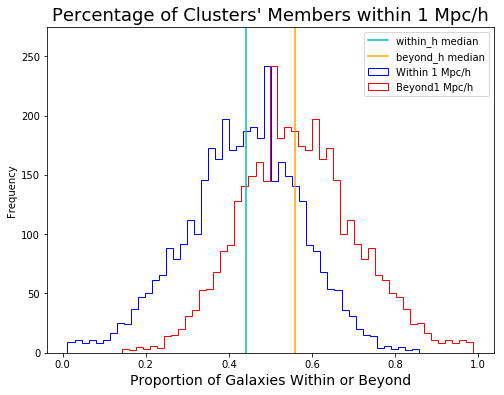

The median proportion of members within 5 Mpc/h of the BCG is 0.7142857142857143.
The median proportion of members beyond 5 Mpc/h of the BCG is 0.2857142857142857.


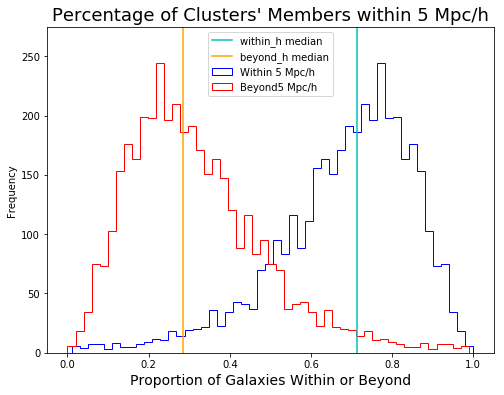

The median proportion of members within 10 Mpc/h of the BCG is 0.7368421052631579.
The median proportion of members beyond 10 Mpc/h of the BCG is 0.2631578947368421.


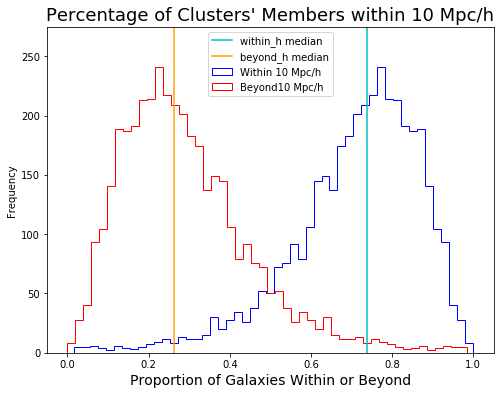

In [302]:
# plot a few graphs

w_med_1, b_med_1 = find_proportions_within_and_beyond(redM_ids, reorg_mem_data, dcmv_constraint=1, percent=50)
w_med_5, b_med_5 = find_proportions_within_and_beyond(redM_ids, reorg_mem_data, dcmv_constraint=5, percent=50)
w_med_10, b_med_10 = find_proportions_within_and_beyond(redM_ids, reorg_mem_data, dcmv_constraint=10, percent=50)
#w_med_15, b_med_15 = find_proportions_within_and_beyond(redM_ids, reorg_mem_data, 15, 50)
#w_med_20, b_med_20 = find_proportions_within_and_beyond(redM_ids, reorg_mem_data, 20, 50)

In [42]:
# let's see when the median starts to fall off

within_50 = np.array([])

within_40 = np.array([])
within_30 = np.array([])
within_20 = np.array([])

x = np.linspace(1,20,20)

for num in tqdm(x):
    
    # time loop
    time.sleep(1e-3)
    
    # run function without graphing portion
    w_50, b_50 = find_proportions_within_and_beyond(redM_ids, reorg_mem_data, dcmv_constraint=num, percent=50)
    
    w_40, b_40 = find_proportions_within_and_beyond(redM_ids, reorg_mem_data, dcmv_constraint=num, percent=40)
    w_30, b_30 = find_proportions_within_and_beyond(redM_ids, reorg_mem_data, dcmv_constraint=num, percent=30)
    w_20, b_20 = find_proportions_within_and_beyond(redM_ids, reorg_mem_data, dcmv_constraint=num, percent=20)
    
    # append values
    within_50 = np.append(within_50, np.array([w_50]))
    
    within_40 = np.append(within_40, np.array([w_40]))
    within_30 = np.append(within_30, np.array([w_30]))
    within_20 = np.append(within_20, np.array([w_20]))

100%|██████████| 20/20 [09:35<00:00, 28.79s/it]


In [43]:
# import fitting tool
from scipy.optimize import curve_fit

In [48]:
# here's a couple functions to try fitting with

# rational function
def f(x,a,b):
    return -a/x + b

# logarithmic function
def l(x,a,b,c,d):
    return a*np.log(b*x + c) + d

# our fitting data
# recall x = np.linspace(0,50,50)
y50 = within_50

y40 = within_40
y30 = within_30
y20 = within_20

# extract best fit parameters and covariance
p_opt50, p_cov50 = curve_fit(l, x, y50)

p_opt40, p_cov40 = curve_fit(l, x, y40)
p_opt30, p_cov30 = curve_fit(l, x, y30)
p_opt20, p_cov20 = curve_fit(l, x, y20)

/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in log


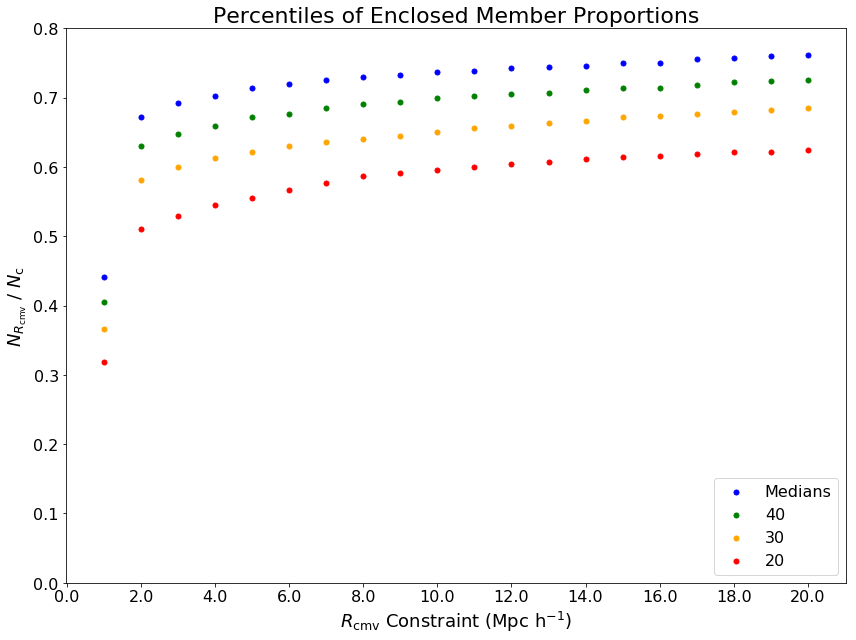

In [53]:
# make a scatter plot

fig = plt.figure(figsize=(12,9))

ax = fig.add_subplot(111)

# scatter
ax.scatter(x, y50, c='blue', s=25, label='Medians')

ax.scatter(x, y40, c='green', s=25, label='40')
ax.scatter(x, y30, c='orange', s=25, label='30')
ax.scatter(x, y20, c='red', s=25, label='20')

# best fits
'''
ax.plot(x, l(x, *p_opt50), 'blue')
ax.plot(x, l(x, *p_opt40), 'green')
ax.plot(x, l(x, *p_opt30), 'orange')
ax.plot(x, l(x, *p_opt20), 'red')'''

ax.set_title(r'Percentiles of Enclosed Member Proportions', fontsize=22)

ax.legend(loc=4, fontsize=16)

ax.set_xlabel(r'$R_{\rm cmv}$ Constraint ($\rm Mpc$ $\rm h^{-1}$)', fontsize=18)
ax.set_ylabel(r'$N_{R_{\rm cmv}}$ $/$ $N_{\rm c}$', fontsize=18)

ax.set_xticks(np.linspace(0, 20, 11))
ax.set_xticklabels(np.linspace(0, 20, 11).astype(str), fontsize=16)
ax.set_yticks(np.linspace(0.0, 0.8, 9))
ax.set_yticklabels(np.array([round(i, 1) for i in np.linspace(0.0, 0.8, 9)]).astype(str), fontsize=16)

plt.tight_layout()
plt.show()

It seems as though most of the member galaxies fall within just a few $\rm Mpc$ $\rm h^{-1}$ of their respective BCGs, which feels like a good sign.

We can also clearly see that the median proportion of galaxies within a comoving distance constraint seems to only start dropping below 0.7 around $R_{\rm cmv} = 4$ $\rm Mpc$ $\rm h^{-1}$ or so. The best fit curve I've included doesn't seem to be that good, and maybe it wasn't necessary, but I think it and the scatter plot still get this point across. When we begin calculating quadrupole moments, if we wanted to constrain our dataset to within some comoving radius of respective BCGs, we could use a smaller value without sacrificing too much member data.

I'm unsure, though, whether or not a median of ~70% is good enough. Let's discuss this at some point.

#### 2. Comoving Radius Percentiles

In [54]:
# define a function that compiles each cluster's comoving radius at a specific percentile
def get_dcmv_at_percentile(cluster_ids, member_table, percent):
    
    # array of dcmv values at percentile
    dcmv_percent = np.array([])
    
    # loop through cluster IDs
    for redM_id in tqdm(cluster_ids):
        
        # time loop
        time.sleep(1e-3)
        
        # find members
        cur_mem_inds = np.where(member_table['cluster_id_member'] == redM_id)[0]
        cur_mem = member_table[cur_mem_inds]
    
        # extract dcmv values
        cur_mem_dcmv = cur_mem['dcmv_to_bcg']
        
        # find percentile's value
        cur_dcmv_percent = np.percentile(cur_mem_dcmv, percent)
        
        # append percentile value to array
        dcmv_percent = np.append(dcmv_percent, cur_dcmv_percent)
        
    # return array of dcmv percentile values
    return dcmv_percent

In [55]:
# now, let's get some different percentiles
dcmv_50 = get_dcmv_at_percentile(redM_ids, reorg_mem_data, percent=50)
dcmv_60 = get_dcmv_at_percentile(redM_ids, reorg_mem_data, percent=60)
dcmv_70 = get_dcmv_at_percentile(redM_ids, reorg_mem_data, percent=70)
dcmv_80 = get_dcmv_at_percentile(redM_ids, reorg_mem_data, percent=80)

100%|██████████| 3895/3895 [00:07<00:00, 526.57it/s]


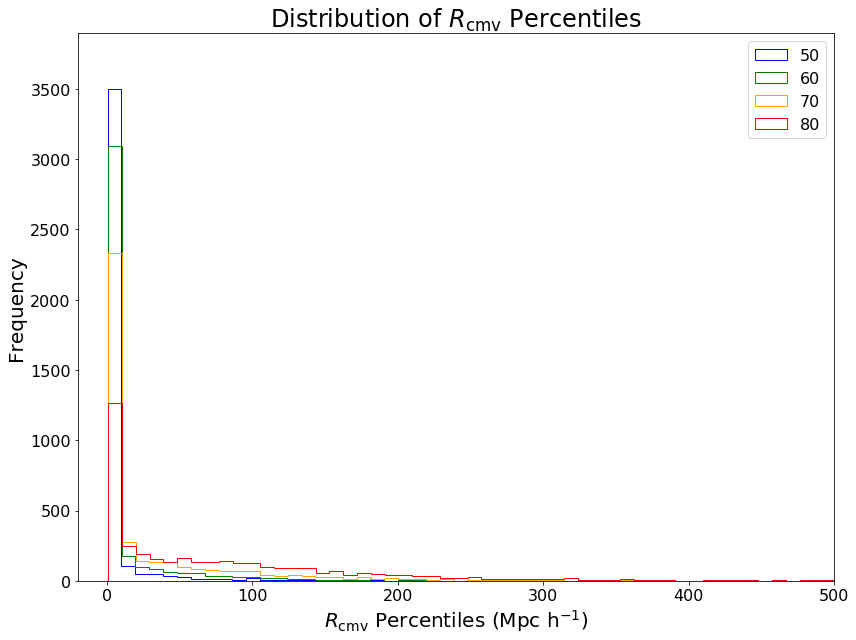

In [56]:
# let's plot and compare histograms for our 4 arrays

fig = plt.figure(figsize=(12,9))

ax = plt.subplot(111)

ax.hist(dcmv_50, bins=75, color='blue', histtype=u'step', label='50')
ax.hist(dcmv_60, bins=75, color='green', histtype=u'step', label='60')
ax.hist(dcmv_70, bins=75, color='orange', histtype=u'step', label='70')
ax.hist(dcmv_80, bins=75, color='red', histtype=u'step', label='80')


# title and axes
ax.set_title(r'Distribution of $R_{\rm cmv}$ Percentiles', fontsize=24)
ax.set_xlabel(r'$R_{\rm cmv}$ Percentiles ($\rm Mpc$ $\rm h^{-1}$)', fontsize=20)
ax.set_ylabel(r'Frequency', fontsize=20)

ax.set_xticks([0,100,200,300,400,500])
ax.set_xticklabels(['0','100','200','300','400','500'], fontsize=16)
ax.set_yticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500])
ax.set_yticklabels(['0', '500', '1000', '1500', '2000', '2500', '3000', '3500'], fontsize=16)

ax.legend(loc='upper right', fontsize=16)
ax.set_xlim(-20,500)
ax.set_ylim(0,len(redM_data))

plt.tight_layout()
plt.show()

Most clusters appear to have small median $R_{\rm cmv}$ values, and it seems as though a majority of clusters have small $R_{\rm cmv}$ values, in the first bin, even up past the 70th percentile. There are a handful of clusters with very high $R_{\rm cmv}$ values at different percentiles, however. Still, I'd imagine that we can extract enough data from each cluster, or at least, in order to calculate its ellipticity.

#### 3. Distribution of Highest Comoving Radii

In [57]:
# array of higher comoving radii values
dcmv_max = np.array([])

# array of redshift ranges
redshift_range = np.array([])

# loop through cluster IDs
for redM_id in tqdm(redM_ids):
    
    # time loop
    time.sleep(1e-3)
    
    # find members
    cur_mem_inds = np.where(reorg_mem_data['cluster_id_member'] == redM_id)[0]
    cur_mem = reorg_mem_data[cur_mem_inds]
    
    # get max comoving radius
    cur_dcmv_max = np.max(cur_mem['dcmv_to_bcg'])
    
    # append to array
    dcmv_max = np.append(dcmv_max, cur_dcmv_max)

100%|██████████| 3895/3895 [00:07<00:00, 555.08it/s]


The median maximum comoving radius is 368.032087360415.


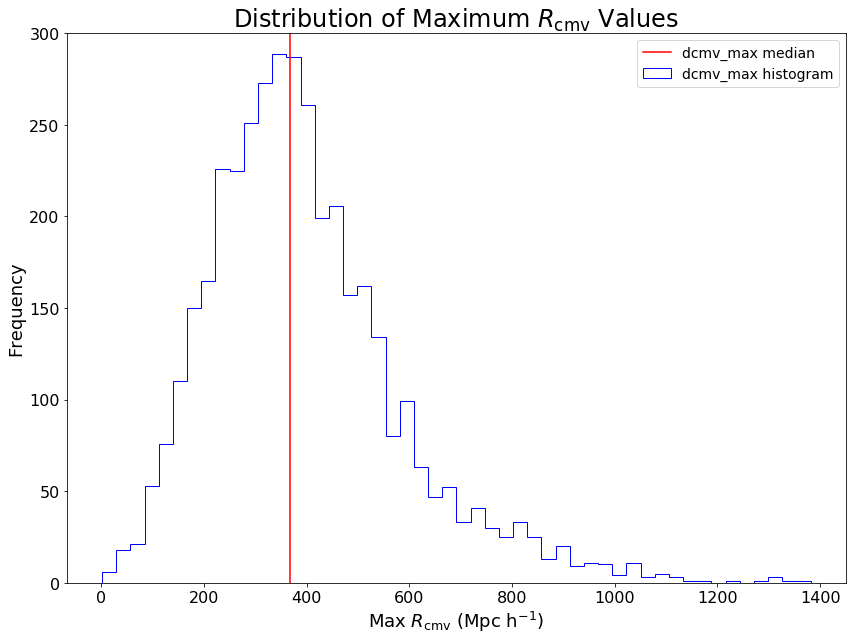

In [58]:
# extract median
dcmv_max_med = np.median(dcmv_max)

print("The median maximum comoving radius is {}.".format(dcmv_max_med))

# get vertical lines at these values
y_max = np.linspace(-1, 1e5, 5)
x_max = 0*y_max + dcmv_max_med

fig = plt.figure(figsize=(12,9))

ax = plt.subplot(111)

# histogram
ax.hist(dcmv_max, bins=50, color='b', histtype=u'step', label='dcmv_max histogram')

# line
ax.plot(x_max, y_max, c='red', label='dcmv_max median') 

# title and axes
ax.set_title(r"Distribution of Maximum $R_{\rm cmv}$ Values", fontsize=24)
ax.set_xlabel(r'Max $R_{\rm cmv}$ ($\rm Mpc$ $\rm h^{-1}$)', fontsize=18)
ax.set_ylabel(r'Frequency', fontsize=18)

ax.set_xticks([i for i in range(0,1401,200)])
ax.set_xticklabels(['0','200','400','600','800','1000', '1200','1400'], fontsize=16)
ax.set_yticks([i for i in range(0,301,50)])
ax.set_yticklabels(['0', '50', '100', '150', '200', '250', '300'], fontsize=16)

ax.legend(loc='upper right', fontsize=14)
ax.set_ylim(0,300)

plt.tight_layout()
plt.show()

An overwhelming majority of clusters have outliers, as is clear in the graph above. Assuming that there are no problems with my code that I'm overlooking at the moment, this might mean we should constrain our member data by $R_{\rm cmv}$. I'll need to look more into my code.

#### 4. Estimated Cluster Radius vs. Proportion of Members within Cluster Radius

$R_{\rm c}$ vs. $N_{R_{\rm c}} / N_{\rm c}$

In [59]:
def prop_within_R_c_multiple(cluster_ids, mem_table, multiple):

    # array of each cluster's respective proportions of members within R_c
    within_ps = np.array([])

    # loop through each ID, get R_c, and find proportions
    for ind, ID in tqdm(enumerate(cluster_ids)):
    
        # time loop
        time.sleep(1e-3)
    
        # get R_c value
        R_c = redM_data['R_c'][ind]
        
        # constraint
        dcmv_lim = multiple * R_c
        
        # find members
        cur_mem_inds = np.where(mem_table['cluster_id_member'] == ID)[0]
        cur_mem = mem_table[cur_mem_inds]
    
        # extract dcmv values
        cur_mem_dcmv = cur_mem['dcmv_to_bcg']
    
        # find where cur_mem_dcmv meets and doesn't meet the constraints
        cur_mem_within_ind = np.where(cur_mem_dcmv <= dcmv_lim)[0]
    
        cur_mem_within = cur_mem[cur_mem_within_ind]
    
        # define proportion
        within_p = len(cur_mem_within) / len(cur_mem)
    
        # append proportion
        within_ps = np.append(within_ps, within_p)
        
    # return array
    return within_ps

In [60]:
# get some proportion arrays for R_c multiples of 1-4
within_R_c = prop_within_R_c_multiple(redM_ids, reorg_mem_data, multiple=1)
within_2R_c = prop_within_R_c_multiple(redM_ids, reorg_mem_data, multiple=2)
within_3R_c = prop_within_R_c_multiple(redM_ids, reorg_mem_data, multiple=3)
within_4R_c = prop_within_R_c_multiple(redM_ids, reorg_mem_data, multiple=4)

3895it [00:09, 429.25it/s]
3895it [00:08, 436.90it/s]
3895it [00:08, 437.56it/s]
3895it [00:08, 442.12it/s]


In [61]:
# necessary to loop through combinations of 0 and 1
import itertools

binaryx2 = list(itertools.product([0,1], repeat=2))
binaryx2

[(0, 0), (0, 1), (1, 0), (1, 1)]

The median proportion within R_c is 0.35294117647058826.
The median proportion within 2*R_c is 0.6382978723404256.
The median proportion within 3*R_c is 0.6818181818181818.
The median proportion within 4*R_c is 0.6938775510204082.


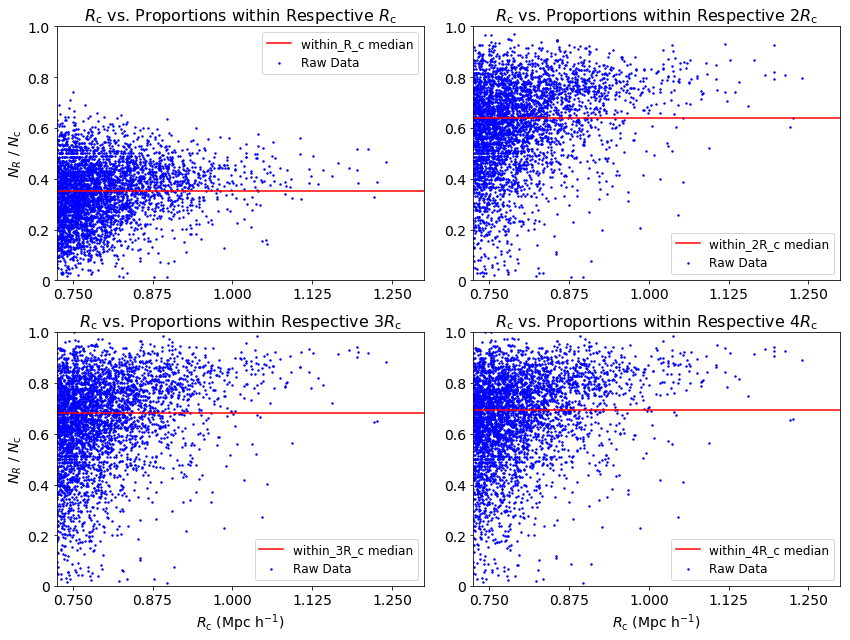

In [62]:
# list of within_R_c
within_lst = [within_R_c, within_2R_c, within_3R_c, within_4R_c]

x_med = np.linspace(-1, 1e5, 5)
y_lst = []
for i, arr in enumerate(within_lst):
    
    # extract median
    med = np.median(arr)
    
    if i == 0:
        print("The median proportion within R_c is {}.".format(med))
    else:
        print("The median proportion within {}*R_c is {}.".format(i+1, med))
    
    # get horizontal line at median
    y_med = 0*x_med + med
    
    y_lst.append(y_med)

fig, ax = plt.subplots(2,2)
fig.set_figheight(9)
fig.set_figwidth(12)

for ind, ixj in enumerate(binaryx2):
    # scatter
    ax[ixj].scatter(redM_data['R_c'], within_lst[ind], c='b', s=2, label='Raw Data')
    
    # plot and legend
    if ixj == (0,0):
        ax[ixj].plot(x_med, y_lst[ind], c='red', label='within_R_c median')
        ax[ixj].legend(loc='upper right', fontsize=12)
    else:
        ax[ixj].plot(x_med, y_lst[ind], c='red', label='within_{}R_c median'.format(ind+1))
        ax[ixj].legend(loc='lower right', fontsize=12)
    
    ax[ixj].set_xticks(np.linspace(0.75, 1.25, 5))
    ax[ixj].set_xticklabels(['0.750','0.875','1.000','1.125','1.250'], fontsize=14)
    
    ax[ixj].set_yticks(np.linspace(0, 1, 6))
    ax[ixj].set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=14)
        
    ax[ixj].set_xlim(np.min(redM_data['R_c']), 1.3)
    ax[ixj].set_ylim(0,1.0)

# title and axes
ax[0,0].set_title(r"$R_{\rm c}$ vs. Proportions within Respective $R_{\rm c}$", fontsize=16)
ax[0,0].set_ylabel(r'$N_{R}$ $/$ $N_{\rm c}$', fontsize=14)

ax[0,1].set_title(r"$R_{\rm c}$ vs. Proportions within Respective $2R_{\rm c}$", fontsize=16)

ax[1,0].set_title(r"$R_{\rm c}$ vs. Proportions within Respective $3R_{\rm c}$", fontsize=16)
ax[1,0].set_xlabel(r'$R_{\rm c}$ ($\rm Mpc$ $\rm h^{-1}$)', fontsize=14)
ax[1,0].set_ylabel(r'$N_{R}$ $/$ $N_{\rm c}$', fontsize=14)

ax[1,1].set_title(r"$R_{\rm c}$ vs. Proportions within Respective $4R_{\rm c}$", fontsize=16)
ax[1,1].set_xlabel(r'$R_{\rm c}$ ($\rm Mpc$ $\rm h^{-1}$)', fontsize=14)

plt.tight_layout()
plt.show()

There is a trend in each of these graphs that looks similar to the mass-richness relation (if the latter were linear), in that there is a triangular-shaped positive correlation. Most of the raw data here have lower estimated $R_{\rm c}$ values, but generally the ones with larger radii have higher proportions of enclosed members.

The difference between these 4 plots aligns as expected with the fitting of enclosed proportions as a function of $R_{\rm cmv}$ constraint. There is a logarithmically increasing difference between them.

#### 5. redMaPPer Apertures

This will use a similar process to the "Member Positions" graph in the GCR test file.

In [63]:
def get_prop_w_in_aperture(radius):
    
    w_in_aperture = np.array([])
    bcg_redshift = np.array([])
    
    # loop through redMaPPer cluster IDs
    for redM_ind, cluster in enumerate(redM_data):
    
        # set aperture radius
        a_radius = radius[redM_ind]
    
        # find members
        cur_mem_inds = np.where(reorg_mem_data['cluster_id_member'] == cluster['cluster_id'])[0]
        cur_mem = reorg_mem_data[cur_mem_inds]
    
        # find BCG
        cur_bcg_ind = np.where(reorg_mem_data['id_member'] == cluster['id_cen_0'])[0]
        cur_bcg = reorg_mem_data[cur_bcg_ind]
    
        # get comoving distance to BCG, one side of the triangle
        cur_comvd = cosmo.comoving_distance(cur_bcg['redshift_member'][0]).value
    
        # get angular separation from BCG to edge of aperture, as it would appear to the observer
        ang_sep = np.arccos((2*(cur_comvd**2) - a_radius**2)/(2*(cur_comvd**2))) * u.rad.to(u.deg)
        #ang_sep = np.arctan(a_radius/a_dcmv) * u.rad.to(u.deg)
    
        # extract member and BCG equatorial coordinates
        mem_ra = cur_mem['ra_member']; mem_dec = cur_mem['dec_member']
        bcg_ra = cur_bcg['ra_member']; bcg_dec = cur_bcg['dec_member']
    
        delta_ra = bcg_ra - mem_ra
        delta_dec = bcg_dec - mem_dec
    
        # calculate angular separation for our members
        mem_ang_sep = np.sqrt(delta_ra**2 + delta_dec**2)
    
        # find members inside and outside of aperture
        within = np.where(mem_ang_sep*u.deg <= ang_sep*u.deg)[0]
        outside = np.where(mem_ang_sep*u.deg > ang_sep*u.deg)[0]
        mem_within = cur_mem[within]
        mem_outside = cur_mem[outside]
    
        # get stats
        N_insMem = len(mem_within)
        N_mem = len(cur_mem)
        within_prop = N_insMem / N_mem
        cur_bcg_z = cur_bcg['redshift_member'][0]
    
        # append
        w_in_aperture = np.append(w_in_aperture, within_prop)
        bcg_redshift = np.append(bcg_redshift, cur_bcg_z)
    
    return w_in_aperture, bcg_redshift

In [64]:
# run through a few aperture radii
w_in_1, bcg_redshift = get_prop_w_in_aperture(np.full((len(redM_data), 1), 1))
w_in_2, bcg_redshift = get_prop_w_in_aperture(np.full((len(redM_data), 1), 2))
w_in_3, bcg_redshift = get_prop_w_in_aperture(np.full((len(redM_data), 1), 3))
w_in_4, bcg_redshift = get_prop_w_in_aperture(np.full((len(redM_data), 1), 4))

In [65]:
# necessary to loop through combinations of 0 and 1
import itertools

binaryx2 = list(itertools.product([0,1], repeat=2))
binaryx2

[(0, 0), (0, 1), (1, 0), (1, 1)]

The median proportion within an aperture of 1 Mpc/h is 0.5694444444444444.
The median proportion within an aperture of 2 Mpc/h is 0.925.
The median proportion within an aperture of 3 Mpc/h is 1.0.
The median proportion within an aperture of 4 Mpc/h is 1.0.


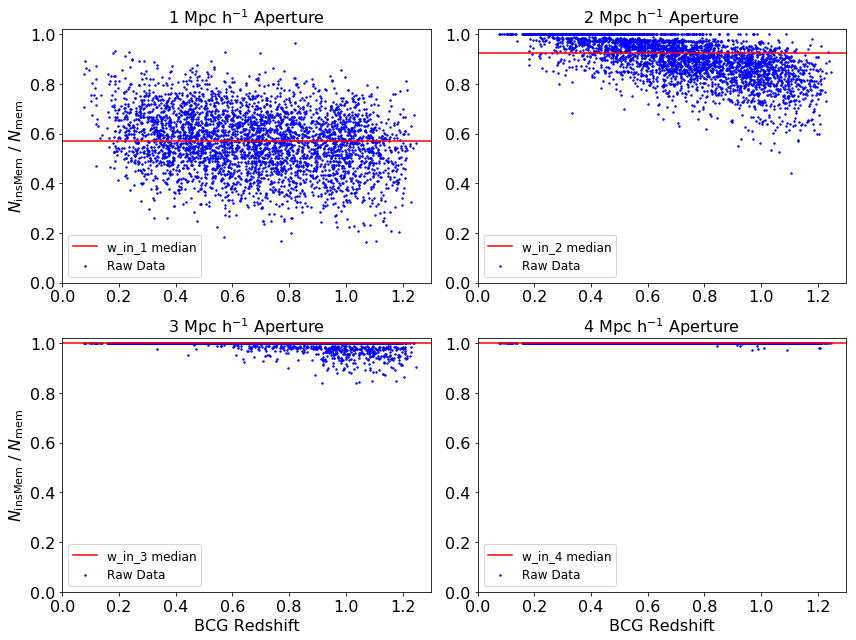

In [78]:
w_in_arr = np.array([w_in_1, w_in_2, w_in_3, w_in_4])


x_med = np.linspace(-1, 1e5, 5)
y_lst = []
for i, arr in enumerate(w_in_arr):
    
    # extract median
    med = np.median(arr)
    
    print("The median proportion within an aperture of {} Mpc/h is {}.".format(i+1, med))
    
    # get horizontal line at median
    y_med = 0*x_med + med
    
    y_lst.append(y_med)

fig, ax = plt.subplots(2,2)
fig.set_figheight(9)
fig.set_figwidth(12)

for ind, ixj in enumerate(binaryx2):
    # scatter
    ax[ixj].scatter(bcg_redshift, w_in_arr[ind], c='b', s=2, label='Raw Data')
    
    ax[ixj].plot(x_med, y_lst[ind], c='red', label='w_in_{} median'.format(ind+1))
    ax[ixj].legend(loc='lower left', fontsize=12)
    
    xticks = np.linspace(0.0, round(np.max(bcg_redshift), 1) , 7)
    yticks = np.linspace(0.0, 1.0, 6)

    ax[ixj].set_xticks(xticks)
    ax[ixj].set_xticklabels(np.array([round(i, 1) for i in xticks]).astype(str), fontsize=16)
    ax[ixj].set_yticks(yticks)
    ax[ixj].set_yticklabels(np.array([round(i, 1) for i in yticks]).astype(str), fontsize=16)
        
    ax[ixj].set_xlim(0, 1.3)
    ax[ixj].set_ylim(0, 1.02)
    
    ax[ixj].set_title('Aperture Radius: {} Mpc/h'.format(ind+1), fontsize=24)

# title and axes
ax[0,0].set_title(r"$1$ $\rm Mpc$ $\rm h^{-1}$ Aperture", fontsize=16)
ax[0,0].set_ylabel(r'$N_{\rm insMem}$ $/$ $N_{\rm mem}$', fontsize=16)

ax[0,1].set_title(r"$2$ $\rm Mpc$ $\rm h^{-1}$ Aperture", fontsize=16)

ax[1,0].set_title(r"$3$ $\rm Mpc$ $\rm h^{-1}$ Aperture", fontsize=16)
ax[1,0].set_xlabel(r'BCG Redshift', fontsize=16)
ax[1,0].set_ylabel(r'$N_{\rm insMem}$ $/$ $N_{\rm mem}$', fontsize=16)

ax[1,1].set_title(r"$4$ $\rm Mpc$ $\rm h^{-1}$ Aperture", fontsize=16)
ax[1,1].set_xlabel(r'BCG Redshift', fontsize=16)

plt.tight_layout()
plt.show()

**Let's try another exercise.** At approximately what aperture radius do we reach the point where all cluster members are enclosed within their respective apertures? To do this, we'll need to loop through a bunch of increasing aperture values, running our function on each one.

If the members are all generally near the line of sight to the respective cluster centers, then we'd expect that this curve would resemble a logistic function between 0.0 and 1.0.

In [83]:
len(np.where(w_in_3 == 1.0)[0]) / len(w_in_3)

0.8803594351732991

In [85]:
# define increasing aperture values
apertures = np.linspace(0, 5, 101)

# array of proportions of clusters for which N_insMem / N_mem == 1
equals_1_prop = np.array([])

# loop through apertures
for r in tqdm(apertures):
    
    time.sleep(1e-3)
    
    # get function outputs for r
    w_in_r, bcg_redshift = get_prop_w_in_aperture(np.full((len(redM_data), 1), r))
    
    # get numerical counts and ratio
    N_redM_allMem = len(np.where(w_in_r == 1.0)[0])
    N_redM = len(redM_data)
    assert N_redM == len(w_in_r)
    prop = N_redM_allMem / N_redM
    
    # append to array
    equals_1_prop = np.append(equals_1_prop, prop)

100%|██████████| 101/101 [16:48<00:00,  9.99s/it]


In [86]:
# find first value where N_redM_allMem / N_redM == 1.0

all_equal_1 = np.where(equals_1_prop == 1.0)[0]
apertures_all_1 = apertures[all_equal_1]

first_all_1 = apertures_all_1[0]
print(first_all_1)

4.4


(0, 1.0)

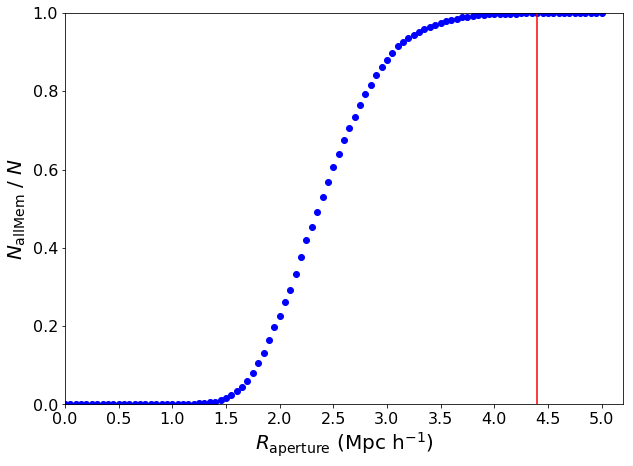

In [98]:
# graph our results: R_aperture vs. N_redM_allMem / N_redM

y_first_1 = np.linspace(0, 2, 5)
x_first_1 = 0*y_first_1 + first_all_1

fig = plt.figure(figsize=(10,7.2))

ax = plt.subplot(111)

ax.plot(apertures, equals_1_prop, 'bo')
ax.plot(x_first_1, y_first_1, 'r')

xticks = np.linspace(0, 5, 11)
ax.set_xticks(xticks)
ax.set_xticklabels(np.array([round(i, 1) for i in xticks]).astype(str), fontsize=16)

yticks = np.linspace(0, 1, 6)
ax.set_yticks(yticks)
ax.set_yticklabels(np.array([round(i, 1) for i in yticks]).astype(str), fontsize=16)

ax.set_xlabel(r'$R_{\rm aperture}$ ($\rm Mpc$ $\rm h^{-1}$)', fontsize=20)
ax.set_ylabel(r'$N_{\rm allMem}$ $/$ $N$', fontsize=20)

ax.set_xlim(0, 5.2)
ax.set_ylim(0, 1.0)

As expected, the relation very closely follows a logistic curve. These results indicate that the first value where all cluster members are enclosed with respective apertures occurs somewhere around $R_{\rm aperture} = 4.4$ $\rm Mpc$ $\rm h^{-1}$, which I believe is not a very large value for this context. While I don't have any more conclusive metrics here, this still seems to indicate that projection effects play a large role in our disparities in comoving distance. For each cluster, redMaPPer's identified members appear to be fairly close to one another according to the 2-dimensional perspective of the observer.

#### 6. Members from other clusters within increasing Radii

In [67]:
test_bcg_ra = redM_data[np.where(redM_data['cluster_id'] == 1722)]['ra_cen_0']
test_bcg_dec = redM_data[np.where(redM_data['cluster_id'] == 1722)]['dec_cen_0']
test_mem_ra = reorg_mem_data['ra_member']; test_mem_dec = reorg_mem_data['dec_member']

delta_ra = test_bcg_ra - test_mem_ra
delta_dec = test_bcg_dec - test_mem_dec

mem_ang_sep = np.sqrt(delta_ra**2 + delta_dec**2)

#reorg_mem_data[np.where(mem_ang_sep <= 0.0533154332548353)[0]]
print(len(np.where(mem_ang_sep <= 0.0533154332548353)[0]))

61


In [68]:
all_mem_ra = reorg_mem_data['ra_member']; all_mem_dec = reorg_mem_data['dec_member']

In [69]:
def get_all_within_circle(redM, galaxies, radius):
    
    prop_mem = np.array([])
    all_counts = np.array([])
    mem_counts = np.array([])

    for ind, cluster in tqdm(enumerate(redM)):
    
        time.sleep(1e-3)
        
        a_radius = radius
    
        # find members
        cur_mem_inds = np.where(reorg_mem_data['cluster_id_member'] == cluster['cluster_id'])[0]
        cur_mem = reorg_mem_data[cur_mem_inds]
    
        # find BCG
        cur_bcg_ind = np.where(reorg_mem_data['id_member'] == cluster['id_cen_0'])[0]
        cur_bcg = reorg_mem_data[cur_bcg_ind]
    
        # get comoving distance to BCG, one side of the triangle
        cur_comvd = cosmo.comoving_distance(cur_bcg['redshift_member'][0]).value
    
        # get angular separation from BCG to edge of aperture, as it would appear to the observer
        ang_sep = np.arccos((2*(cur_comvd**2) - a_radius**2)/(2*(cur_comvd**2))) * u.rad.to(u.deg)
    
        bcg_ra = cluster['ra_cen_0']; bcg_dec = cluster['dec_cen_0']
    
        all_delta_ra = bcg_ra - all_mem_ra
        all_delta_dec = bcg_dec - all_mem_dec
        
        mem_delta_ra = bcg_ra - cur_mem['ra_member']
        mem_delta_dec = bcg_dec - cur_mem['dec_member']
    
        all_ang_sep = np.sqrt(all_delta_ra**2 + all_delta_dec**2)
        mem_ang_sep = np.sqrt(mem_delta_ra**2 + mem_delta_dec**2)
    
        all_within = galaxies[np.where(all_ang_sep <= ang_sep)]
        mem_within = cur_mem[np.where(mem_ang_sep <= ang_sep)]
    
        a, b = esutil.numpy_util.match(all_within['id_member'], mem_within['id_member'])
    
        mem_within_in_all = mem_within[b]
        assert len(mem_within_in_all) == len(mem_within)
        prop = len(mem_within_in_all) / len(all_within)
    
        prop_mem = np.append(prop_mem, prop)
        all_counts = np.append(all_counts, len(all_within))
        mem_counts = np.append(mem_counts, len(mem_within_in_all))
        
    return prop_mem, all_counts, mem_counts

In [70]:
prop_mem_1, all_counts_1, mem_counts_1 = get_all_within_circle(redM_data, reorg_mem_data, radius=1)
prop_mem_2, all_counts_2, mem_counts_2 = get_all_within_circle(redM_data, reorg_mem_data, radius=2)
prop_mem_3, all_counts_3, mem_counts_3 = get_all_within_circle(redM_data, reorg_mem_data, radius=3)

3895it [00:28, 135.47it/s]
3895it [00:30, 127.36it/s]
3895it [00:30, 129.40it/s]


In [71]:
prop_arr = np.array([prop_mem_1, prop_mem_2, prop_mem_3])
all_arr = np.array([all_counts_1, all_counts_2, all_counts_3])
mem_arr = np.array([mem_counts_1, mem_counts_2, mem_counts_3])

Text(0.5, 1.0, '$3$ $\\rm Mpc$ $\\rm h^{-1}$ Aperture')

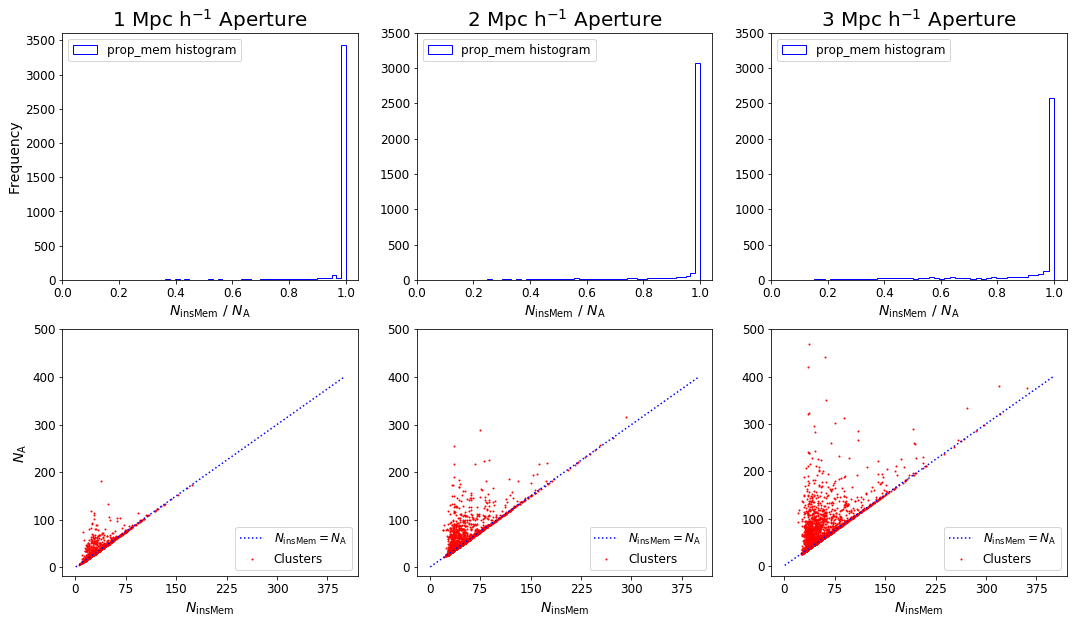

In [72]:
x = np.linspace(1, 400, 5)
y = x
    
fig, ax = plt.subplots(2,3)
fig.set_figheight(10)
fig.set_figwidth(18)

# scatter
for i in range(3):
    #ax[0,i].scatter(bcg_redshift, prop_arr[i], c='blue', s=2, label='Raw Data')
    ax[0,i].hist(prop_arr[i], bins=50, color='b', histtype=u'step', label='prop_mem histogram')
    ax[1,i].scatter(mem_arr[i], all_arr[i], c='r', s=1, label='Clusters')
    
    ax[1,i].plot(x, y, ':b', label=r'$N_{\rm insMem} = N_{\rm A}$')
    
    #top_xticks = np.linspace(0.0, 1.2, 7)
    top_xticks = np.linspace(0.0, 1.0, 6)
    ax[0,i].set_xticks(top_xticks)
    ax[0,i].set_xticklabels(np.array([round(i, 1) for i in top_xticks]).astype(str), fontsize=12)
    
    #top_yticks = np.linspace(0.0, 1.0, 6)
    top_yticks = np.linspace(0, 3500, 8)
    ax[0,i].set_yticks(top_yticks)
    ax[0,i].set_yticklabels(np.array([i for i in top_yticks]).astype(int).astype(str), fontsize=12)
    
    #ax[0,i].set_xlabel(r'BCG Redshift', fontsize=14)
    ax[0,i].set_xlabel(r'$N_{\rm insMem}$ $/$ $N_{\rm A}$', fontsize=14)
    #ax[0,0].set_ylabel(r'$N_{\rm insMem}$ $/$ $N_{\rm A}$', fontsize=14)
    ax[0,0].set_ylabel(r'Frequency', fontsize=14)
    ax[0,i].legend(loc='upper left', fontsize=12)
    
    down_xticks = np.linspace(0, 375, 6)
    ax[1,i].set_xticks(down_xticks)
    ax[1,i].set_xticklabels(np.array([i for i in down_xticks]).astype(int).astype(str), fontsize=12)
    
    down_yticks = np.linspace(0, 500, 6)
    ax[1,i].set_yticks(down_yticks)
    ax[1,i].set_yticklabels(np.array([i for i in down_yticks]).astype(int).astype(str), fontsize=12)
    
    ax[1,i].set_xlabel(r'$N_{\rm insMem}$', fontsize=14)
    ax[1,0].set_ylabel(r'$N_{\rm A}$', fontsize=14)
    ax[1,i].legend(loc='lower right', fontsize=12)
    
ax[0,0].set_title(r"$1$ $\rm Mpc$ $\rm h^{-1}$ Aperture", fontsize=20)
ax[0,1].set_title(r"$2$ $\rm Mpc$ $\rm h^{-1}$ Aperture", fontsize=20)
ax[0,2].set_title(r"$3$ $\rm Mpc$ $\rm h^{-1}$ Aperture", fontsize=20)

#### 7. Comoving distance to respective BCGs vs. Probability of cluster Membership

I'm pretty sure the `reorg_mem_data` table already has properly aligned `dcmv_to_bcg` and `p_member` values, so we can just graph this.

In [105]:
# extract two wanted parameters
dcmv = np.array(reorg_mem_data['dcmv_to_bcg'])
p_mem = np.array(reorg_mem_data['p_member'])

In [122]:
# let's get some dcmv percentile bins
# this still runs quickly, but there has to be a more efficient (i.e. less lines of code) method

percentile_values = []
dcmv_bins = []
p_mem_bins = []

for ind, i in enumerate(range(20, 101, 20)):
    
    # since there's no recursive percentile to refer to
    if i == 20:
        value = np.percentile(dcmv, i)
        indices = np.where(dcmv <= value)
        dcmv_bin = dcmv[indices]
        p_mem_bin = p_mem[indices]
        
        percentile_values.append(value)
        dcmv_bins.append(dcmv_bin)
        p_mem_bins.append(p_mem_bin)
    
    # where I will refer to past iterations
    else:
        prev_it = ind - 1
        
        value = np.percentile(dcmv, i)
        previous_value = percentile_values[prev_it]
        indices = np.where((dcmv <= value) & (dcmv > previous_value))
        dcmv_bin = dcmv[indices]
        p_mem_bin = p_mem[indices]
        
        percentile_values.append(value)
        dcmv_bins.append(dcmv_bin)
        p_mem_bins.append(p_mem_bin)

In [127]:
range(20, 101, 20)[1]

40

The median p_member value for bin 1 is 0.9714676737785339.
The median p_member value for bin 2 is 0.9305634498596191.
The median p_member value for bin 3 is 0.8639907836914062.
The median p_member value for bin 4 is 0.7486420273780823.
The median p_member value for bin 5 is 0.41224412620067596.


(0, 1)

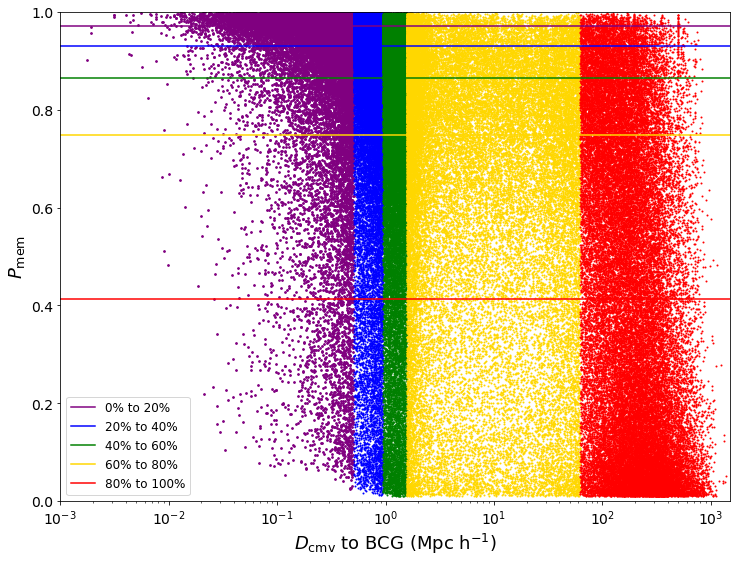

In [239]:
color_lst = ['purple', 'blue', 'green', 'gold', 'red']

fig = plt.figure(figsize=(12,9))

ax = plt.subplot(111)

for i in range(len(dcmv_bins)):
    
    # for each bin, get the median p_member value and plot the line
    p_med = np.median(p_mem_bins[i])
    
    print("The median p_member value for bin {} is {}.".format(i+1, p_med))
    
    x = np.linspace(0, 1e4, 5)
    y = 0*x + p_med
    
    if i == 0:
        ax.scatter(dcmv_bins[i]
                   , p_mem_bins[i]
                   , c=color_lst[i]
                   , s=3
                  )
        ax.plot(x
                , y
                , color_lst[i]
                , label='{}% to {}%'.format(0, range(20, 101, 20)[i])
               )
        
    else:
        previous_i = i - 1
        ax.scatter(dcmv_bins[i]
                   , p_mem_bins[i]
                   , c=color_lst[i]
                   , s=1
                  )
        ax.plot(x
                , y
                , color_lst[i]
                , label='{}% to {}%'.format(range(20, 101, 20)[previous_i], range(20, 101, 20)[i]))

ax.set_xlabel(r'$D_{\rm cmv}$ to BCG ($\rm Mpc$ $\rm h^{-1}$)', fontsize=18)
ax.set_ylabel(r'$P_{\rm mem}$', fontsize=18)

xticks = np.logspace(-3, 3, 7)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks.astype(str), fontsize=14)

yticks = np.linspace(0, 1, 6)
ax.set_yticks(yticks)
ax.set_yticklabels(np.array([round(i, 1) for i in yticks]).astype(str), fontsize=14)

ax.legend(loc='lower left', fontsize=12)
ax.set_xscale('log')
ax.set_xlim(1e-3, 1.5e3)
ax.set_ylim(0, 1)

In [238]:
np.percentile(p_mem_bins[4], 56.567)

0.5000391362297537

The horizontal lines are color-coded to match their respective bins, and they represent their respective bins' median $P_{\rm mem}$ values.

Of course, a solid majority of members lie fairly close to their respective BCGs, and most of these have fairly high $P_{\rm mem}$ values. However, we care more about the final couple of percentiles in this graph. Thankfully, we do see a pretty significant drop-off in $P_{\rm mem}$ values in the outermost couple of bins. However, it feels as though it doesn't drop off enough. There is no way a supposed member located hundreds of $\rm Mpc$ $\rm h^{-1}$ away from a cluster's BCG should have a $P_{\rm mem}$ value of even 0.4. That being said, maybe projection effects or something along those lines might explain this as well. Ultimately, we can use a $P_{\rm mem}$ cutoff of around 0.5 and eliminate most of the outliers, but there's still a fair number (over 40%) that would remain. A $D_{\rm cmv}$ might still be necessary.

### Extract One Cluster

This cluster is the one that I use in my GCR test, also found in this folder.

In [61]:
# get smallest and largest IDs for one cluster, will be used to query the get_quantities function
clusters = np.unique(redM_ids)
cluster = clusters[0]
one_cluster = reorg_mem_data[np.where(reorg_mem_data['cluster_id_member'] == cluster)]
print(np.min(one_cluster['id_member']))
print(np.max(one_cluster['id_member']))

4000531618
4001943549


In [62]:
# this is the cluster (cluster ID 1) that I used in my gcr test, also found in this folder
one_cluster

mag_z_lsst_member,refmag_err_member,p_member,theta_i_member,mag_i_lsst_member,ra_member,theta_r_member,magerr_g_lsst_member,magerr_i_lsst_member,cluster_id_member,mag_y_lsst_member,refmag_member,pfree_member,magerr_z_lsst_member,magerr_y_lsst_member,mag_r_lsst_member,mag_g_lsst_member,magerr_r_lsst_member,dec_member,redshift_true_member,id_member,x_member,y_member,z_member,redshift_member,dcmv_to_bcg,index_reorg_member
float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64
22.373661041259766,0.0323040746152401,0.12359227240085602,1.0,22.744705200195312,50.17814085973227,1.0,0.05159137770533562,0.024878066033124924,1,22.171871185302734,22.373661041259766,1.0,0.0323040746152401,0.04451210796833038,23.761577606201172,25.133922576904297,0.031035777181386948,-31.145342797385947,0.5690668225288391,4000531618,1154.9172038763343,1384.7105214293574,-1089.5523339929716,0.5690668404244217,578.8003839434352,55021
21.599916458129883,0.020763855427503586,0.08042027801275253,1.0,22.023969650268555,50.17034297118035,0.9999604821205139,0.044891562312841415,0.02082090452313423,1,21.201114654541016,21.599916458129883,1.0,0.020763855427503586,0.024549685418605804,23.2497501373291,24.811025619506836,0.03075704723596573,-31.114668853493406,0.6342937350273132,4000751615,1269.8791718818773,1522.1655509841275,-1196.3280906139964,0.6342937514804166,370.2165605163865,55022
20.996320724487305,0.014319696463644505,0.02704525552690029,1.0,21.422143936157227,50.07344261516842,0.920137345790863,0.028568945825099945,0.018986091017723083,1,20.65546989440918,20.996320724487305,1.0,0.014319696463644505,0.02515452727675438,22.61460304260254,24.198392868041992,0.02342911809682846,-31.148916314723223,0.6919025182723999,4000855416,1370.0237435354313,1636.5471638424297,-1289.7585586762764,0.6919024983552968,191.8278493143281,55023
22.2967529296875,0.03535545989871025,0.25955823063850403,1.0,22.638713836669922,50.17979788771395,1.0,0.04394949972629547,0.024201620370149612,1,22.007991790771484,22.2967529296875,1.0,0.03535545989871025,0.054759759455919266,23.82598876953125,25.146352767944336,0.043038785457611084,-31.203223343976596,0.6782712936401367,4000914401,1340.3831804302376,1607.198194047095,-1267.3639861630722,0.678271310237921,238.94061894453034,55024
22.645065307617188,0.03561076894402504,0.8670969605445862,0.06089901924133301,23.13766860961914,50.0802766563703,0.9992694854736328,0.07196616381406784,0.02503846026957035,1,22.310304641723633,22.645065307617188,1.0,0.03561076894402504,0.05268234759569168,24.36345863342285,25.968107223510742,0.03785271197557449,-31.18611735140271,0.7332167625427246,4000985118,1434.5924914722711,1714.0643912301937,-1352.650301221391,0.7332167531267111,72.9844500528516,55025
21.208419799804688,0.01782834529876709,0.45950639247894287,1.0,21.632795333862305,50.141298224156955,0.9998916387557983,0.031201312318444252,0.015961702913045883,1,20.980318069458008,21.208419799804688,1.0,0.01782834529876709,0.028746116906404495,22.819650650024414,24.18175506591797,0.022626353427767754,-31.223030493731617,0.7332437634468079,4000992891,1433.1377915933099,1716.028347821303,-1354.9544213523327,0.7332437875142535,71.29961939990133,55026
22.28604507446289,0.02455759048461914,0.35205867886543274,1.0,22.667383193969727,50.11357957420053,1.0,0.038533877581357956,0.028668764978647232,1,22.134506225585938,22.28604507446289,1.0,0.02455759048461914,0.058574188500642776,23.720678329467773,24.984437942504883,0.02892112359404564,-31.154491264230565,0.7308648824691772,4000999493,1431.9870639854755,1712.970916318222,-1349.447244993398,0.7308649027739453,76.75136986804632,55027
20.99263572692871,0.027657756581902504,0.22496338188648224,1.0,21.47078514099121,50.14339408418509,1.0,0.03836165368556976,0.01899944245815277,1,20.676761627197266,20.99263572692871,1.0,0.027657756581902504,0.03381611406803131,22.7504158

The median comoving radius for cluster ID 1 is 1.3470227422157703.


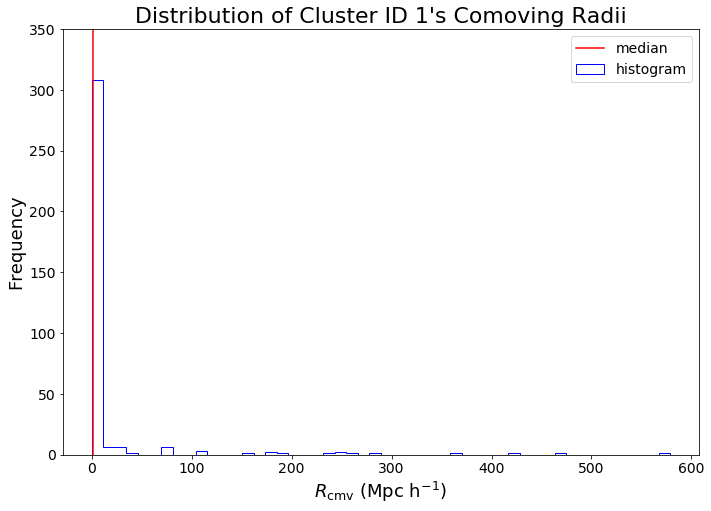

In [63]:
# extract one_cluster's dcmv values
dcmv_redM_id_1 = one_cluster['dcmv_to_bcg']

# extract median
dcmv_redM_id_1_med = np.median(dcmv_redM_id_1)

print("The median comoving radius for cluster ID {} is {}.".format(cluster, dcmv_redM_id_1_med))

# get vertical lines at these values
y_1 = np.linspace(-1, 1e5, 5)
x_1 = 0*y_1 + dcmv_redM_id_1_med

fig, ax = plt.subplots(1,1)
fig.set_figheight(7.2)
fig.set_figwidth(10)

# histogram
ax.hist(dcmv_redM_id_1, bins=50, color='b', histtype=u'step', label='histogram')

# lines
ax.plot(x_1, y_1, c='red', label='median') 

# title and axes
ax.set_title("Distribution of Cluster ID {}'s Comoving Radii".format(cluster), fontsize=22)
ax.set_xlabel(r'$R_{\rm cmv}$ ($\rm Mpc$ $\rm h^{-1}$)', fontsize=18)
ax.set_ylabel(r'Frequency', fontsize=18)

ax.set_xticks(np.linspace(0, 600, 7))
ax.set_xticklabels(np.linspace(0, 600, 7).astype(int).astype(str), fontsize=14)

ax.set_yticks(np.linspace(0, 350, 8))
ax.set_yticklabels(np.linspace(0, 350, 8).astype(int).astype(str), fontsize=14)

ax.legend(loc='upper right', fontsize=14)
ax.set_ylim(1e-2,3.5e2)

plt.tight_layout()
plt.show()

The two graphs are identical to one another. For this cluster, at least, extracting data from HDF5 files worked properly. I had more confidence that the correct data for this one cluster was extracted using GCR than H5py, but there appears to have been no difference in the results between the two methods. So, since H5py is far less costly, I believe we should use it.